In [1]:
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import cartopy.crs as ccrs
import iris
import iris.quickplot as qplt
import matplotlib.ticker as mticker

In [2]:
MOM6_DIR = Path('/g/data/gb02/pag548/ocean-config-for-rcm3-dev/input/tiny-ocean-land-rcm3-dev/')
UM_DIR = Path('/home/548/pag548/code/UM_config_tools/scripts')

ocean_mesh_file = MOM6_DIR / 'access-rom3-ESMFmesh.nc'
ocean_mask_file = MOM6_DIR / 'ocean_mask.nc'
hgrid_file = MOM6_DIR / 'hgrid.nc'

In [3]:
# Load in for visualisation
ESMF_mesh = xr.load_dataset(ocean_mesh_file)
ocean_mask = xr.open_dataset(ocean_mask_file)

nx = len(ocean_mask.nx)
ny = len(ocean_mask.ny)

ESMF_mask = xr.DataArray(ESMF_mesh.elementMask.values.reshape(ny,nx), 
            dims=['ny','nx'],
            coords={'ny':ocean_mask.ny, 
                    'nx':ocean_mask.nx})
                    
hgrid = xr.open_dataset(hgrid_file)

# To extract lat/lons from the hgrid (Madi's method)
# --- MOM6 native mask 
# Mask is defined at T-cell centers. Lat/lon at these points can be extracted from hgrid:
geo_lon_t = hgrid.x[1::2,1::2]
geo_lat_t = hgrid.y[1::2,1::2]

lons = geo_lon_t.values[0,:]
lats = geo_lat_t.values[:,0]

ESMF_ds = xr.DataArray(ESMF_mask.values,
                        dims=['lat','lon'],
                        coords={'lat':lats, 
                                'lon':lons})

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/distributed/diagnostics/nvml.py:14: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml


Text(0.5, 1.0, 'Original test land/sea mask')

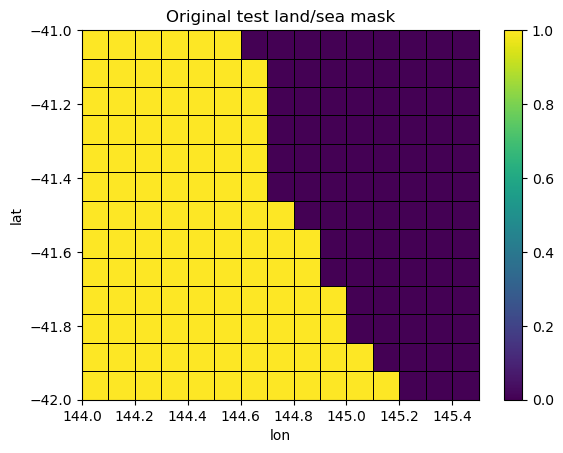

In [4]:
fig,ax=plt.subplots(1,1)
ESMF_ds.plot(ax=ax,vmax=1,vmin=0,edgecolors='black',linewidth=0.5)
ax.set_title('Original test land/sea mask')

In [5]:
# Note, we can also plot the mask by using the Mesh file connectivity lists. See https://gemini.google.com/share/aa910f049570
nodeCoords = ESMF_mesh.nodeCoords.data

# Find the min and max 
lon = nodeCoords[:,0]
lat = nodeCoords[:,1]

elementConn = ESMF_mesh.elementConn.values
elementMask = ESMF_mesh.elementMask.values

elementConn_0based = elementConn - 1

tri1 = elementConn_0based[:, [0, 1, 2]]
tri2 = elementConn_0based[:, [0, 2, 3]]

# Stack the new triangles
triangles = np.vstack([tri1, tri2])

# Duplicate the mask data for the new set of triangles
facecolors = np.hstack([elementMask, elementMask])


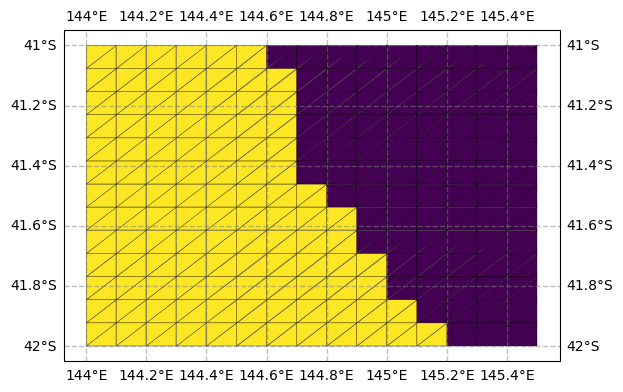

In [6]:
# Plot the mesh, navigated onto a lat/lon grid. These will render as triangles
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree()) # Or another projection

plot = ax.tripcolor(
lon,                       # X-coordinates (Longitude) of the nodes
lat,                       # Y-coordinates (Latitude) of the nodes
triangles=triangles,       # Connectivity matrix for the triangles
facecolors=facecolors,     # Data defined at the element center (mask values)
cmap='viridis',            # Custom land/sea colormap
vmin=0, vmax=1,            # Set min/max for the colormap to ensure 0 and 1 are covered
edgecolors='k',         # 'k' or 'lightgray' to show grid lines
transform=ccrs.PlateCarree() # Specify the coordinate system of the input data
)

# Plot lat/lon axes
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
              linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlocator = mticker.FixedLocator(np.arange(144., 145.5,0.2))  # e.g., every 30 degrees longitude
gl.ylocator = mticker.FixedLocator(np.arange(-42,-40.8,0.2))    # e.g., every 15 degrees latitude

In [7]:
cons_grid = xr.open_dataset ( UM_DIR / 'dummy_cons.nc' )
cons_grid

<xarray.Dataset> Size: 7kB
Dimensions:           (latitude: 36, longitude: 24)
Coordinates:
  * latitude          (latitude) float64 288B -41.99 -41.96 ... -41.04 -41.01
  * longitude         (longitude) float64 192B 144.0 144.1 144.2 ... 145.4 145.5
Data variables:
    land_binary_mask  (latitude, longitude) float64 7kB ...
    geog_cs           int64 8B ...
Attributes:
    Conventions:  CF-1.7

In [8]:
print(f'Cons grid latitude values are {cons_grid.latitude.values[0]},{cons_grid.latitude.values[-1]}')
print(f'Cons grid lon values are {cons_grid.longitude.values[0]},{cons_grid.longitude.values[-1]}')
print(f'Lat delta = {cons_grid.latitude.values[1] - cons_grid.latitude.values[0]}')
print(f'Lon delta = {cons_grid.longitude.values[1] - cons_grid.longitude.values[0]}')

Cons grid latitude values are -41.986111111111114,-41.013888888888886
Cons grid lon values are 144.03125,145.46875
Lat delta = 0.027777777777785673
Lon delta = 0.0625


Text(0.5, 1.0, 'Regridded test land/sea mask')

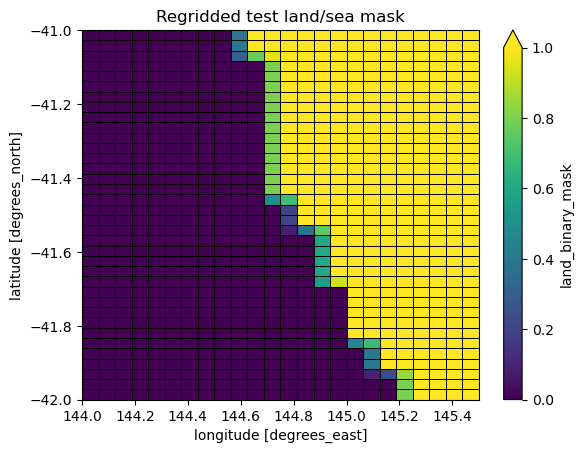

In [9]:
fig,ax=plt.subplots(1,1)
cons_grid.land_binary_mask.plot(ax=ax,vmax=1,vmin=0,edgecolors='black',linewidth=0.5)
ax.set_title('Regridded test land/sea mask')

In [10]:
# This produces the following outputs from `ancil_lct.py`. By default, land_binary_mask values < 0.5 are discarded. 

In [11]:
TEST_ANCIL_DIR = Path('/scratch/gb02/pag548/cylc-run/u-dg767/share/data/ancils/Lismore/era5')
v = iris.load( TEST_ANCIL_DIR / 'qrparm.veg.frac_cci_pre_c4_MOM6')

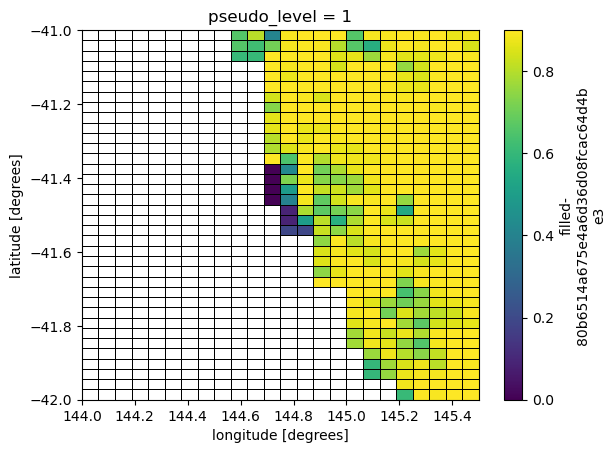

In [12]:
fig,ax=plt.subplots(1,1)
xr.DataArray.from_iris(v[0][0]).plot(ax=ax,edgecolors='black',linewidth=0.5)

In [13]:
# We can alter the 
l = iris.load( TEST_ANCIL_DIR / 'qrparm.landfrac')

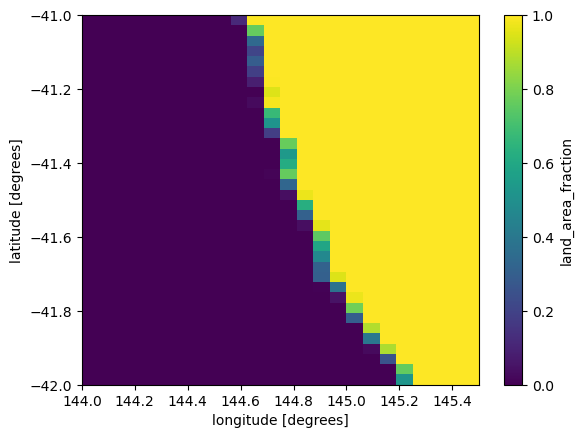

In [14]:
fig,ax=plt.subplots(1,1)
xr.DataArray.from_iris(l[0]).plot(ax=ax)

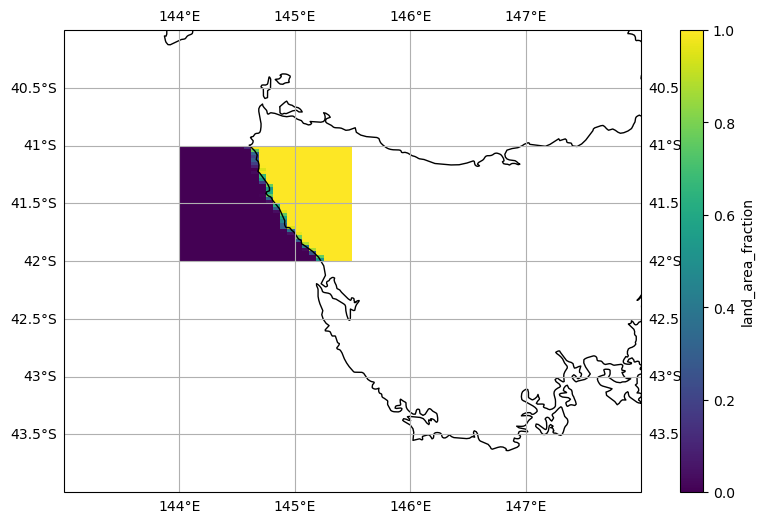

In [15]:
# Lets plot this with a larger domain and coastlines
land_frac=xr.DataArray.from_iris(l[0])
map_proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={'projection': map_proj})
land_frac.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_extent([143,148,-40,-44])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.savefig('qrparm.land_frac.png')

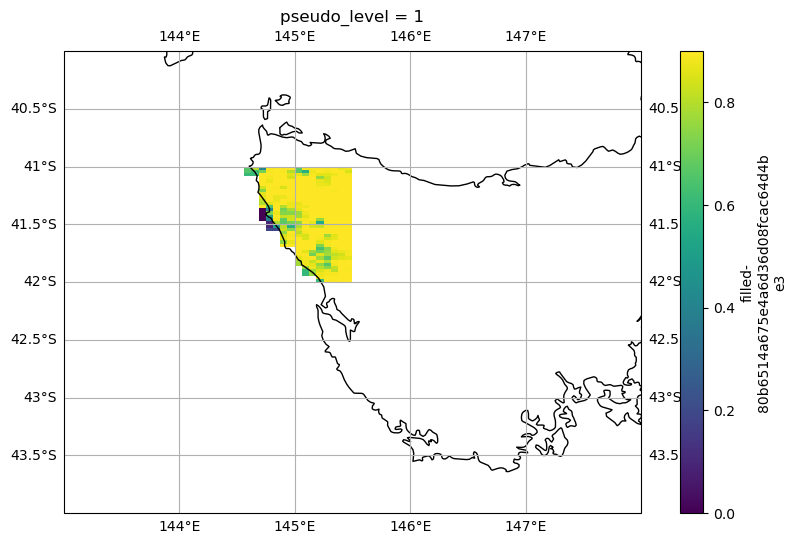

In [16]:
#Try with other grid
veg=xr.DataArray.from_iris(v[0][0])
fig, ax = plt.subplots(figsize=(10,6), subplot_kw={'projection': map_proj})
veg.plot(ax=ax,transform=ccrs.PlateCarree())
ax.set_extent([143,148,-40,-44])
ax.coastlines()
ax.gridlines(draw_labels=True)
plt.savefig('qrparm.veg.frac_cci_pre_c4_MOM6.png')

In [17]:
# Let's load the target land-sea mask and underlying vegetation ancils as cubes to mimic
# the logic in ancil_lct.py

In [18]:
target_cube = iris.load( UM_DIR / 'dummy_cons.nc' )

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/coords.py:1982: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.10/lib/python3.11/site-packages/iris/coords.py:1982: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


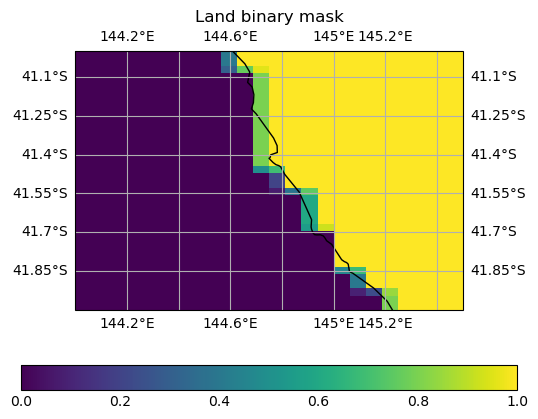

In [19]:
qplt.pcolormesh(target_cube[0])
plt.gca().coastlines()
plt.gca().gridlines(draw_labels=True)

In [20]:
# OK so when we load our target by default, it is inverted.
source_path='/g/data/access/TIDS/UM/ancil/atmos/master/vegetation/cover/cci/v3/vegetation_fraction.nc'
source=iris.load(source_path)